In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!wget /content/drive/My Drive/Dataset_Faces/data.zip

In [ ]:
!unzip -q "/content/drive/My Drive/Dataset_Faces/data.zip"
print("Data is unzipped")

Data is unzipped


In [ ]:
from sklearn.datasets import load_files  
import numpy as np
from keras.utils import np_utils


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    mask_files = np.array(data['filenames'])
    mask_targets = np_utils.to_categorical(np.array(data['target']), 4)
    class_names = data['target_names']
    return mask_files, mask_targets, class_names

# load train, test, and validation datasets
train_files, train_targets, class_names = load_dataset('data/train')
valid_files, valid_targets, _ = load_dataset('data/val')
test_files, test_targets, _ = load_dataset('data/test')

Using TensorFlow backend.


#Load Image

* Read Image
* Preprocess Image
  * Resize
  * Preprocess_input

In [ ]:
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input

def load_image(path):
  image = cv2.imread(path).astype(np.float32)
  image_resized = cv2.resize(image,(250,250))
  image/=255.0
  image = preprocess_input(image_resized)
  return image

def load_dataset(files):
  for i, file in enumerate(files):
    vector = []
    for file in files:
      vector.append(load_image(file))
    return np.array(vector)


train_X = load_dataset(train_files)
test_X = load_dataset(test_files)
val_test_X = load_dataset(valid_files)


In [ ]:
print(train_X.shape)
print(val_test_X.shape)
print(train_targets.shape)
print(valid_targets.shape)

(2354, 250, 250, 3)
(292, 250, 250, 3)
(2354, 4)
(292, 4)


# Data visualization
  

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.5)
rows = 6
columns = 2
for i in range(10):
    ax1 = fig.add_subplot(rows, columns,(i+1))
    ax1.imshow(cv2.cvtColor((train_X[i]*255).astype('uint8'), cv2.COLOR_BGR2RGB ))
    title = ("Class_name "+ class_names[np.argmax(train_targets[i])])
    ax1.text(0, -2, title, size=10)
plt.show()

In [ ]:
Number_of_Clases = 4

# Model architecture

In [ ]:
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization

In [ ]:
model = Xception(include_top=False, input_shape=(250,250,3), weights="imagenet")

layer = model.get_layer('block13_pool')

flat = Flatten()(layer.output)
class_ = Dense(1024, activation='relu')(flat)
outputs = Dense(4, activation='softmax')(class_)

model = Model(inputs=model.inputs, outputs = outputs)

model.summary()

# Model summary

In [ ]:
import keras
optimizer = keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model

In [ ]:
#Image augmentation
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10,
		zoom_range=0.2,
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.2,
		horizontal_flip=True,
		fill_mode="nearest"
        )

datagen.fit(train_X)

#Save best model
checkpoint = ModelCheckpoint('best_model1.pt', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(datagen.flow(train_X, 
                                 train_targets,
                                 batch_size=32),
                    epochs=100,
                    callbacks=[checkpoint],
                    validation_data=(val_test_X, 
                                     valid_targets))

# Load Best Model

In [ ]:
from keras.models import load_model
model.load_weights('best_model1.pt')

# Model evaluation

In [ ]:
score = model.evaluate(val_test_X, valid_targets)

print('Test accuracy: ', score[1])

292/292 [==============================] - 1s 5ms/step
Test accuracy:  0.9349315166473389


In [ ]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    return class_names[predicted_class]

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
scores = model.evaluate(test_X, test_targets, verbose=0)
print('Accuracy: %.2f%%' % (scores[1]*100))
y_pred = model.predict(test_X)

Accuracy: 95.97%


In [ ]:
print(classification_report(y_pred.round(), test_targets))
accuracy = accuracy_score(test_targets, y_pred.round(), normalize=True)
f1score = f1_score(test_targets, y_pred.round(), average='weighted')

              precision    recall  f1-score   support

           0       0.94      0.99      0.96        67
           1       0.95      0.95      0.95        78
           2       0.97      0.96      0.97        74
           3       0.97      0.95      0.96        79

   micro avg       0.96      0.96      0.96       298
   macro avg       0.96      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298
 samples avg       0.96      0.96      0.96       298



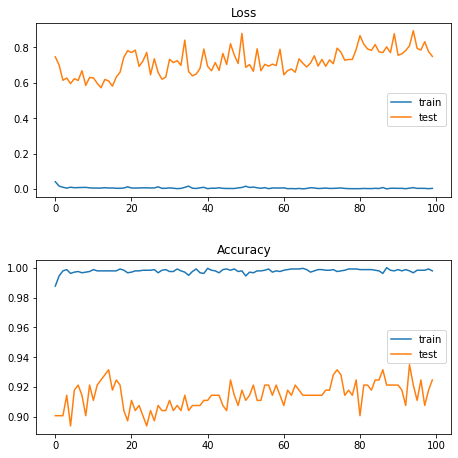

In [ ]:

figure, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,7))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
figure.tight_layout(pad=3.0)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import urllib.request
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_preprocessed  = cv2.resize(image, (250,250))
  image_preprocessed = preprocess_input(image_preprocessed)
  return image_preprocessed, image

def predict_url(url):
  image_preprocessed, image = url_to_image(url)
  predicted_class = get_prediction(image_preprocessed)
  plt.imshow(image)
  plt.title("Предвидено : " + predicted_class)

# Predictions :

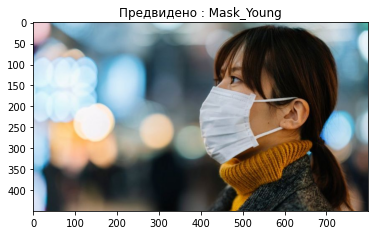

In [ ]:
predict_url("https://ichef.bbci.co.uk/news/800/cpsprodpb/E907/production/_110755695_gettyimages-1202072951.jpg")

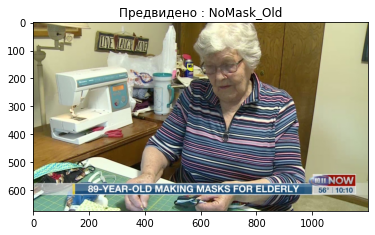

In [ ]:
predict_url("https://gray-koln-prod.cdn.arcpublishing.com/resizer/J78VpyO8C969QDLa8cnO3pfeLG8=/1200x675/smart/cloudfront-us-east-1.images.arcpublishing.com/gray/DJ2P5AJ5VRODDDTUBIJMGPJF54.png")

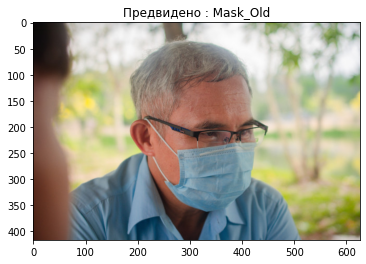

In [ ]:
predict_url("https://image.freepik.com/free-photo/old-man-using-face-mask-protect-corona-virus-covid-19-when-communication-with-people_10541-1759.jpg")

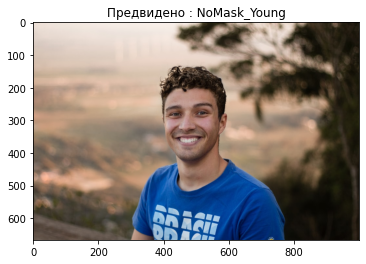

In [ ]:
predict_url("https://images.unsplash.com/photo-1536548665027-b96d34a005ae?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80")

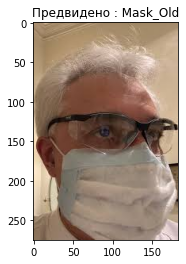

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRydIoYSikh0xrwUH3zCJ7eJ2NpOFTD3RwL3Q&usqp=CAU")

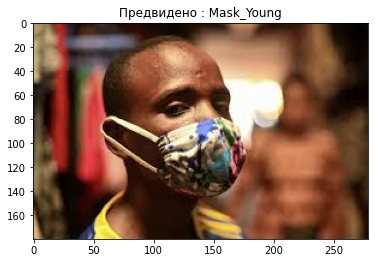

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS--HB-SuYb_c4pHj_Jh9qZpmC9EoNrT9LJhw&usqp=CAU")

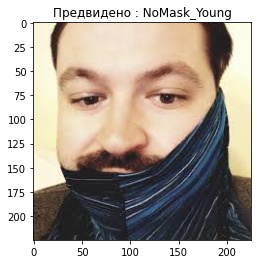

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRHWmu4DrQdg081nEBO1vsdh_rxU8o9oheXHg&usqp=CAU")

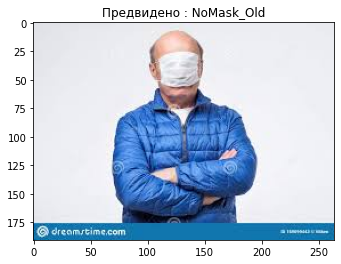

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRt7p2Fr2Qjm2K44EKaosQQKiP9JQ11__tdfw&usqp=CAU")

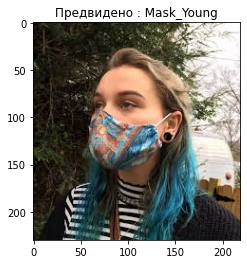

In [ ]:
predict_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFRUXGRgXGBgXGB0XGBgfGBgaGh0aGBgaHyggGxsmHRgYIjEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGi0lICYtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAOYA2wMBIgACEQEDEQH/xAAcAAACAwADAQAAAAAAAAAAAAAEBQIDBgABBwj/xAA/EAABAgQDBgQEBAUEAgIDAAABAhEAAyExBBJBBSJRYXGBBhORoTKxwfAUQtHhB1JikvEjcoKiFUMzwhZEsv/EABoBAAIDAQEAAAAAAAAAAAAAAAIDAAEEBQb/xAAqEQACAgICAQMDBAMBAAAAAAAAAQIRAyESMUEEIlETYXEjMsHwQpGxFP/aAAwDAQACEQMRAD8A8dkMFJJN27XhkrFA0WCBYEVI5H+YdIXBLah7DmD7D7tF00HykUrnmDhYIgGgy5Cq37j01+6xdNQAlgcpLFw4+xzgDDlqEwdL0Jpw4X9oFggcuU6srA2H7QSvdUEDS7dfv1i1clLhSXBcKA0LX9w8dOM5OcMxsH9YjYSZVMOYBRDsWYHS9NeNekdzZJSgAhnrd79KEs1YrUTUpt84p8/q/X6RAbOvL7xYFi3D7rEsLIuSM2rPXrFyMMkooo5ySyGdwG9DenKIQnhMSwYUNyrXhr1ieVQeY53Wqw434enOBkUIcFgWIsffny0i/DZU5gU53SaORlZi4Y1YA3pWBIclJufb69YslKIJLZsocg1oW5cIjhd5gkVH5jbvxOkFYVflzC4CkrcEkli5d3BD1EUQ6wUsrISVMWblUj/PYwZipGTg2WjMXYXIFib+sWjZChL81OXIc1QScrKYuWYAc/5hdxA+DnzUhRAQSygCWIZQOZhxY0bjAshfM2asJ8xSSMpylrgs+VQ0LVHGO8PIITmRVLELUQ6UAlgSdDzi7Cbcmy5QkEAy82fIoMxKWcKuLg9haCNlYVM9akLX5Upj/ppoVAAqy5jcJypqq9OBIoglwiVrLAXsON2Yfpw5Rt/COyJmHMnEkDy17qiUZ8t0rChWgrU2aGvgzw5h1Td7/wBQzgghSSczJKSQXoAT2o0MvEuPm5mwxUlMwqzqUyZZCEqzlL6k0PMUaL+4XEZeAhicpUVSp0kZ0IKRkCFJUQrKAmqVEAuCLxqJ+1QhQlhjNLOkEkAaFRAo/qYx3h44tUr8PIkiThwhP+sXExWZLlSUEuCQwep14RpdiKWmX5YbMgA5CjISNSpdQompe/GGQ0qKIztkqmTkTJyioAOkENLCjdkvQsBlNTU10ic3AI80rRKBmpYAqBTdqlTVAHWzaxdiMVMSM2XzEEOrMQCgC9vi7cIjINfMUrOLBILlIp8RBY/DfnzgtED5GAISEqWS2idwd2LnuYMQgAMIDnYgpUGBIYkir8mGpgFM+eVUVlsSSMzcggV4VJgrSIPIHmCsclBZHxpP/H94mEK/m9oKyj4xlB6E100tSnA/OGCJTywFaLUa/wC1It29oBSpOgFGNbVpQcdYZmbllpNFEqq/DLUDh+8LYSF2dILB1HUmg7CL1qJS5DWAftFUzIFVSQ78x98ol+HSpsqgr1cdohCP4gluPFz9YkcQWqX/AM26RKfK9T9uYjhkF2ZzrpEBohNmOOUTlyApL2qx5c+kdzN0sruNRzjsfE1WPbWIQjLWSq8FpO6k01rrpzoz3gTEghixHeIpUxufkIlEJlWrvWvOL14wLADUTmCRwzM9dbaxOXKStL2JN9NdPWHGy/DSlZVrIlC9aq6kGnq0A2kWot9CbDTTLJKCapylwGqzs9mOorBWHk+YtIzAFRyuajor0jQr8NYZmVPV/wAUD5AiLJnhfKnNKJnJSxKXyLbVgQ/cWgeSCeOSEmExq5JUlKlJSsFKkPRYLZkkGmg6sIvlL3T+UAgMHNC5IBaos7nSK14YpBS4FVFibAgCnPQxzCzck0EKSfLLkK3gcpdjxFG6GKewKHMsmaxypKlhKEFxUgHfoaKGUvYb0A/ifLWwFBukDUPWvNhE8NtKWDlKU1dKQHARmAqku9wP7amphdJnLzEEHONS9Ku31imiz0TZfiXDiVKlollM8qAC3SlLlQDzFvQEcRx5QfiZOGxJ8uZiklG7kEskplzFndd/iU+YuaAPRNowWCMwZ1hCVkJJOdmA13Tc/Uirs+i8I4qQT5UxwJhUcoSZYQp6OpBYhmYmxJozGLRfKzUeHcAmYnKrETErlKIUZJA8xNkklIZmILqqK9Y1+ImlLGVLzqG8xVvNlL5TYqJDM/CAdhrQjDrSiTmQleRMvMkhkhKblqUeObR22lMvMtZk7xSCxUApJIINMzC+gaGKkigzZ+IlzSKmWpLvKmpAVU0UU9XqHrrDgEoA3QR/TRh0hJgsdhp6A60qAtQBTir8Qewg/wD8lJlEIVODmyVKBV7Vgk0UMWChxBjpUoaUIsYpl4pNWCyCf5FfUW5wShTwaaZCCktW3HnEc0WqDiKC3GLIfGmHQxL1agcXro/yi8qUEgEMmppDDbEhO7MQNxQqHcA6iF4Va5a3T6Qu7ITmhiQbcDY9DHaAkW15/Ix1NckE6izx0osXNjb75xAky2co5QkEgXrvEnmW9rRQZCtAS9+daNE5QJdwYullQJKeDWcXs2sUV2AKRBUts1cxHAFz6iDsJJQvdUAk0NHZndRAFSw0D24xAYZQWcqFMaoe5DPmTZwa17aRLJRzFIlD4DwDKYqc37Xr0iGCkFawkFCb1PIFh9OEELBWQ6U8PhCSWNbC9Y5Iw2VYo4+jCKsurHuwcCAkTVixZIuOZjra2PKcwer/AH9IKxk0+WkJBYQIjYs6eaJIfUi1G/SFNq7ZpjF1SAsBiyS5Ue0ajAY5IY5mbmae4EJ1+F5surP8oFnrmy/yAHiQ/wBIq0+guMo9mwmjA4hvNKQtiAtLpNeNSDeE+3vC84OtEzzpZrmTUDKLKAqGAp0gDZm2yCy7a6j0MehSsGky0TpJbMKgGhPcHKfbpFW0C4KR5WnB2JBdixalHqD29o6nHeAUAS4qpqvxBj1B0zDlWjMrTMlKiOgYa/KMjjNgzJeJ3pQXJUSXAZLAvoBk4fYg7ESg0KcHOTKUCoBYqClJrZnDgpD94JwE1SloKCklZDBylSSSQHKr0F6j5RTi5IUpk2JYAiiTwD1014w92T4eXhcWgTQMwdYQXGfRpa6b7VBqHYcovtCwqXOxqlJkN8KiQgJMrOWdRKgQeNaQ+2fgNoKbLMw0t3dJK3oWzLBqVN2IFY2+Ew8qZLKSRmIdbpCVhWji4I509YPwc8FLEfC6TSlDfvwg1AujH4DwNNlzTN8xJzXAUpJ6pVldJdjzraNnJSZaW8sdgD6l3PpFQnywHSSFGwTX2t/mCcMpag6g33w+7wail0QvlzEtYjsfpEvPTxHenziKZoDj7rFnmB2gyjsKexgYzTw947xSRdh3ELVy0kuEgd/2ibLR8qSsSoIUgWNxSrN+ggaZ/MD2iTG3ziqfODbvGFpFUWZqA/fT2iwKFBaOwBkDudT3P7RPKCKfvFNl0RFnr/mGOE8t2UTl4gVHNn4mK8BswzlplIUgLUzBasoJZRYPqMv/AGETmYGZLWEzB5RNgWAYg/nJYA82imWXEqSd7KznLUZkkWUUgug1vQGo5RXjMYpWQrplSEpUKAAaEJo4LurV3MUpWlyACocaJFAbh9QLVtFycegq3UMjOCA+Yjd+HMrQqcsenMUQNGKWoPOmFas2cKJzOCCCX1elXqw4UL8M7Bm4uaSiksGqyLDQc1coUYWTMnzUykjL5igMo+F9VNpYktHuOw8AiRKTLlhgkdydSeZhWWfFUjT6fFzdvoHwPh2VLSA2YjU3/aHGGwiEhgBEFKjiZhjG232dJRSVILThUHQekD4zYkiYN6Wk9otlLMXpXEFys868ReC0J3pYbkI78I7Q8ofhp3wKok8C9O1vsx6DPlZhGD8VbKyupI5tDIzfTAlBPaGWISZamUKcRw49PuloMlS5a0FKiClVw5HooFxGV2V4pSQJM53FEqIzerF+4jQYaQpTFGUg1uD3B1hnQkQ+KfCJ3Z0kOgfER8Qb4aChFTXRh1hfs8CfORKxU5aFIVlSVlSxR3QoFQI3gLVj0vCTGYHpXXsdYVeKNgSSlc1KFGYtmUFNlINiDRi5rpSCjIzZMVbQfj9rzMKc05IUgfAUq3wNXDVFtdRe8V4TbicQve3Q7lJoBUAAMWUompUaCg4mMXMnr3U4lK1ISnJusChFw5Yk6348Y3vhVWGkyzLlZ5iVgKyZa2APxMSLXpWGxdsUaTDSUN+QvqDVtHPHlEsVicoJBoGctT9qQNJw8oHelpB/KAAAH+vWLtorTly8dXt1h6KLMRRIX0P7wOjEqcsA5UADcfbR2CpMsWUNR8w+hoeUAzZwQRmLB6cDqPSLssaS8WSpizN7xf8AhXrQdv3joSwzhioV++0dGeRoexH1iymfIiyEnuQTy51aKpqEEuhi16C3F4ksDQswNg5MUy1jS46VhZAt9xAVrmAYN+YfV4pTiGNqPZ+ESFUp46P1P6RWZlWIF3txHKIXZJWJJIIDM7ffGKp09ahlBOW7E0rq1n5wTNwSQgEKDs+UElh10NLNF+H2Zmz7wCEtWmYvRwW+EEpd2oX0iaIAImVAzFqdCz/qfWCcMmgTRyos1bQR+BAWlIUhecCiS9R/UN1y5twgmVhwHoAU0vWj056mKbIjY/w+2eMxmqHw7qfqfRh3MelylgikeR7F2nPkBKcrIbvWrmNzsjaeZLxiyq3Z1MDSjRopionKmjjGf2ntDKHjGbQ25iCohKmHpC4xsc5qJ64FA8Im0eO4I4lVTOb1h/s7G4yWQQsTB/KSfrBPH9xfO/B6LmhB4hSCDBezdqpnJqkoWLpV8wdRHWNkODC+mX4PKsbITnII1cEUPrD7wnt8S1CUtRA0zGx4E27/AKUB8QyGUXp8v2jOLnEhRN0j1r/mNUVyRll7WevTNrozZFbp0cs78H/z7OerEZpakk3FKg+jax5jszFfi5XkKP8Aqy/gU9VJLEOeLMO0P/D+z5jDOteXUBR/WBcaBuxptLZImZBaYQU0tUuT7n1hlspE8qyKlFCwABMJKso0BSCAzDUs9KwNNkrlFRR5hSsBJUkk+W3EB86VFg2maCdmo2gFB2WAlRAdpaqgBlXFCaGG4/kzTq6NFPw5yDdzEfEoIKTS9H9niOAwYVVw7lgrNXRiSXgrZ+LK05ZgyTBdNUiwqlThxCnam20IACVpUpSsg3gUtclZsB89I0WuwRoraglpAUAOIdnppxqwaAps7znATlL0UUsEkMSFPoWY9YVyjNmKKpQEwjiwQ5+J3JUBawb5xcrYalATELUpdil2lhh8IQG9yRA8rIOdnTpak5gWJd8yqpIJDEPoXgeYFOW8s88zHuBrCuVORhZr5SgTGC0KKgnNpMQauD8JHFrQVN2pU/6Z9CfcJMEmXR8uodyKlqn94j+HLuQEpF6u36mJeYVMl2YNEMQsndTpStX5sdYiKDZ7eWilND3Uw94pnTwEhgBbmO7/AEi0TAJSKUqXFLFvn8oCAOYWu/214pECc4Ukg6CrWqB7OPeLsPtGZmUHKitOQvqCKp4EMBU2aKfxAJAYBnDj8zl68DEZpCN0EPYmrCxp1+nC8IWLmsQkbrEMa8/QPb1hqnF0BuGD8XAF6dbfSAcBPlFac1QHKnSCVOGYABr2dhfpFu0VyypZluATQEcuPV4potDo7TSpRSpeQD+kq9WsOcanwW8yd5buGKgRUMP8xnfDWwQtctS3qUEhwLsI9N8ISZEta7CcuuU0LDROh4kiM2RJLRuxuTexX4pkFAYR59ipxfpfVo9r2pgBMBeMHtbw1lWFZbFwBY9eMLg0ux0030ZjAbRkKZJVOQr+ZgtNnqkVEM8PjFIIZaVpNloND1Gh5GL9n7JCFFpd6Oan3t+0Ptn+DZCt4pKVHUEj6tBzcAYRyeQzYuMzEPcWOsaRaXEK9neGhLIIUSOcaFEhhGd7GXRg/FuCdBLR5aZrLIOtI922/gs0tXSPENubOIWSC0PwPwZ/ULyiODnLlrC0F24aiv0ePTsLtbIETv8A1rIzf0qNz0N+rx5nsmTMmnImStauKaX4lTAaG8azYxm4WcnB4pBEuc+XMBcWUlSVFJ0BAL2oIbNJiIppX4N9tDESlSylQLFmYOOR4xn9m+JJuFmkq8tTkHKVFJL7uZNABQJFahrQccBkHlkmxAap5M4r06Rltp7KmoQJ5KciVp8whW9K3txYS2YtwBJcFqQMY+RGTse+LfFWJUU+bLSmSRZJzCYMzhltYgEAg6GsV7NxqMROlrVLWHTloxlpSCG+IBgQGLGrtwhTsDGJK0fiZqp0mXMeWQCoFW7ZayMqWUpRSW+FyKxqp+JwhxSJkiQvMFqQViStt5JWFgAAKqHBuHJIFIJvfYFjrZ2Ew+VM0TkIW6ksSgJWyjTKGrr1hnh9pKmTCAUpWlIrorkRrpdiPnKRsmUzoYkELZQ+IgDfq5BbWsVbQVmSolIK0gsqgBANa8uB10hyTSCQLtmamajyV7q1cat/Uk6sQS/MCjwBLx+IlDyzhFTctPMDgKbVnp00g1MpUsF7pAImXKauEgvupNiHAIJNHEdKx2Y5vNlIeuRfxJ4g10iBHzSEs7JodW587UilYILDhTW3HlBOFS4LtpS/dvSOYZTrCVBhZ/vSLsEniSBLCabjCnMOfd4ASoG3uH+xDAS8yZjkVIJbiHtEMPKSHC1ZQwILZn000iWVYNOnrUXLAlOWzPp8qRKelyOiXryv6xUtIcgGx4RGcqrcAB6CLLJqQzaVvf0jQeDcH589KZhBSApan0CeJ6kRnDaNL4bwhTLVMPwzGljmxBUOQLp9InHlonLjs9Lw0iWtCly5mSrJUBUhJYkWYEm+rRbjVbiVLSSkjOqYmhQUlipP9TjM3MxDYaAtDAlKUhlbvK7m/p15z2hh5gShKas5zMSFOSokv9HreBwLFz9z68DPVPMsfsT32/70aDYGMVNQpl+cEFgtmUoVuniBc0cvSCp0pKwxEZLCzZkopnYYs3xylEMprso0Bu78Rxqzk+LxPOXJ5awwIIqTqSWs/wB6QHqcMb5R19hnovUTrhPf3GMrCJTzg6ViE6Qm2btbzVKQtOQpZ6gseF66avyiU6agOfMGUEB2IuHjJ9HJx5Vo3vNi5cG9/BoEYgRPzhGLm+JJCFMpazzQgke5HrFuD8XYZSwgldWDgZmdrgVF/YwcPT5ZK0hGXPghLi5bNPi94ER59jNly8MsqmBMyeS6JZrLkvZU0fmXqEWFzoI9AnYnKlpZdR/P/LyTz56RjdryUCTNcgLABBPHMPdiYBPh+Q6+otdf9E4m4lSylJ+KucMSSdXhDtDaE3yELmKKzLxKcpNxuqzAcnCfSHPhyStE1IIoHUWswqTGc22kqX5QtLLq/wB6y6vQU9YLGrmFldY9nsux5smdITMW2UpBe+mvv6Ri/EWwsSoKmYVC5mHKk/6aFFS7lRUxDBjmYX33a8OPACknDeWpylKmIYnMxcgAVjWq2ihCky0pnOskgIklJmBIA3szWAFaWHfTGOjlS2zAbA8LeWvyFyprzWc0CUoKVkraoWQNQAQSzh41WwthYcmYmVOZTjezKE0oUc2VSVbwqWzBntGon7RWAD5JNWcrSPkSX5NGdnbKnFYVJSJGUhQBUovUPU0Z6sXck8aW4b+SqNGECTLSLkAJoPiItu6ddIV7QxJCVpWQCp1M75RU3FGO9cwqPmGa8wzCSSmihvU5AMm1LcoDnbJRLQQZikq+BWZ2ZXwqD1uG9bQVhJGzwWNQpDJmJoKqajs5yvdvaM9idhYWYorIDlnZ0izWzQXLQZUlRCgRVKQ1mJalakVMdScGkJAKULLVUUOSTUueMF2To+Y8JLF3zPRuMWIZTkOGBFTWtPsxSmWKB25FtYI/DUZJcB+VtawIFlcmWav8NPXWK5+YPZnDP8xF8qWCwdr1Z4liJeYqA0Y1Gn0vFXshVMwbMoEHN2D8uUCrTXe17u0FTFkpAU4awanCBjJLtWhNxBL7lohMpag4F/WNv4GmFUoyvy+aFN/xT+kYtcpqXbWN/wDw9SABxOb6D6RHvQUXW0bzZMvKwUk+XmOa1wBzsAPaDvEuLATmSCpIPAh+IBbhAmFmKSVb6jybdSG4FnNDq9h1OxwE2SUpNQT1FTRqc/SE5MXF8h+LNHLUZJ9d/wAmeARMBWgA6mrEGtCNDACcEZ6gCjLaoqdL/wCNbRzEYJcs5w6TTl6jo8PsLjE8wAa7oN2Pzhs831aUVsXH0/8A5vdPrw0waZgMMlASxzpo5N2Fyzamg5wJjMQFMAXA0TXon1N4N27PQbPmFKUf+o8YzaMUmpdyymA1YfE560ozl+UHCP1Wo9JdgSn9CLyPcpdfgcyJCQEJmBJcgqALm7AdBV34HjCfbW2QlctUtYTkDICAAHZwQBUk0FXuYjhZ5nMhI3iyKVbV+ozeo5wdjPDcuSULIq7I6j/IjqRWqRxZSp22bDZmPz4cTFo8tQcrBVnNQFOpiWUQXy6OIxG3fG0jDzVSlyDOIIKiCMqSQDlY/ERThDZM2bOw8/yglJlGUcrMZgSAFOX+LdFf6BxjznxFh0YpfmyZssBRzLBIBCiACSdbRxMkIyzSfhnosU5wwRX+SPT8f4gw/wCFVjJapZQEJ3UJZSlq+FCtRW45HgY8/wALh1eWVLqtSipX+5Ss3qwfueEcCk+RJw6CFIlErJAouYp95R1CQSANam0E4+aEIloBrmCj2oAedX7wMYKOkTLmckrN74E+FQ473C/2YfzthIM/zz5hWwTuzWoHoxSGfrGb/h/O+Etdh1r+5j1NEoEVSD2h7itGPHO2/wAivBBIAJzZk0ClkEj6d7xZjAtYopzwNB7QwOEln8o+XyiBwCNHHf8AWL0HYk/ChB3gXvmJuWvwYcLCKfEqEHDKUlyQggC9/qLj/aYerwBbdW3UP8mhBtOemQVJmUSpQIvSm8zX6c4FlplSUlaUolKzVv1ILBzw3o00qSlICWFBwjHbM8QYaXhpTO4QLDeUoUYe55RTMlTJp8wzSnMAWE4JAoNMh+cS6LqzwH/xjGp6Bqn6v+kFLScoTQKao/Xn+8XycRnfK4a7HQ8Tw/WBihlAWULUoX9jAW32KsoWoouHFG5GITEOpw5NQRewb5CDlTMwLpLDi9je1GjuScqipACnDMb/AOWiXoJP5FqVB94dDr3jqZMB1LvcGjdGaOlned7kkf4+kQLl+JI4fekGi6CZUkrUwYvx07RuvChAlTR+ZDKvcN+xHeMZsieA5N6N2Bh7sXHiXMFgFDKvvr2Ji12BJmtw21wQllVuqpuakV0/SGq8eUBy5dwQ5463rHnDKlrU3+4c+nFo12CmPJM1RqA4DbvJzyv2hU4yk9m3FPHGFJdj+k1BPEs5FaflVwP68YrmqEsEqo3DlT3L+kZ/Z+MUmckpUbuvRwdD2r3gTxBtV6AuXr14Q6GOWNcvLWjLkyLLNQ8R7LPxXnTPLfKlicxqwrU6Ek6cHg+RsaWlIVNUwygk2B3mFdaJPC+kYebjSCz/AJT2f7bo8SxGNnTAErUcruOgdugqY2YXHFGqMPqOeebldHqmxZmEwkgLUoZ1EqCQAS1n4h7wgxXiVK8QSQVkMEgWSNWHHR9PlmMMHJd1UvFchagTl3QLkXPeM2TPOTbb0acPpYwarbQ42j4nGGmKKEBQIfKahyKJPFlVjzrAygTWvzPeD9szneKNmpY5jQJIHf8Aa/pC49aHzbvY7ws/IHOmnyHWLsUCoyw9SnOo8HU/0aFJJVMCTRvi+UNpYzK6s/aw++Ji4wtip5OMbN/4EokHQEfo/wB8Y9STiGSFCr8Lx5R4axASlLakj0FI9B2bPJHwgtqSzQ7LD2WYvT5azOL8jqTMVqCDwd4KMzr6QAF/0nsYtXODfn9Iz0dF7CCttfaFPinZ4nSFAfEN5J5i36d4OGIH8xHURIzQR8QMU0RHi2BWQKl1NpYB7N84YjE/1H1I9ol4ok5cQtAYapLaGtO7jtClSV8VHuP0hSkMPK8PivLJVLO8QUl6hiLjt8oKwmNWEgHeyVynUDrbTrACHALXLsR7fKOwSllD74/WHtISi+TOIUMr5RYHgbvBkmYnMW+FruzQOtAABAAzD04D6xbhMMFugFlXAPEUYEcX9oFouiExF66u+kQRKuaMbe332iyWGJBBux/wYnPw24a1URlHLefrVosiBgC9aMYPwwpWApCmLXFukHypbA01godi8j0XzsYQADpYwwwOOCQzkhVTU35+0IMarSBBilJAKTSCnErFN1Rp/wAYUEkl7NzprC+ZiFLJr34dzaAE41SgH++0McPgcyEqe9WvEeTzJlrE6qKOpSQ7/ET/AGjpxh7JwssHfW5+9Pu0KRJbSDcNLEKnlTY3HgdB03ED4UBgzPb0gPEMEtFyoUbYxRG6LmE25s0KMca0JcerMSBWrQV5dMosB/n76QFIrMYafP8Az8odS5O7MPBgP7Qf1jUkY5y2CYJRZ+N40+w8JmUAxNqC5LW5cX/SEWHl0SOA+zGr2XMEspL5aBVL1Bo/FiY0QhoxZp7CvDE6pTwGYdTUetPePS9jzwEglQAI1t90MeceHQkzaB3SH5MSg+grG58KpStKSqpSrIQdCKW6vDpr9KjJjb+umM04oziyQtCa72UpdqMCbQdmUKV/u/aJLmVACSRqrQfrHR7xgSO0cExXP5x2CbsfT944GiwTkggFQBOkX0Tsz23dlS500ZlELysLe4I5wvV4Neonhix+B7jkqG/imfky8wWLWyuS/JvlGYw+25RSD52V65d6n9rBoU1G9hJs8MxaWIszUI9OPKJJS4DluFI5MQhgEuWe/C9tI6kLdYzdeAg/BSClqHQOQ4FK1HeKkTWqTvF3PEanvwiWJU4A6Hu1elvV4ns/DZy5JPalKF4rwWwoSgSksQDZuHNzf9qF4hjZTKAChlD71SD6tbtBCJZVNKX3dBpa44RPZ2y1zZxQjKEqCjmW4lsgpKhQHMoFYDAEuYFbKE0pZJDqLPT7MN0m59fSGa9jSZZLYbGz1M4Pkqky9PhJSVqFvyJgHHYkEACSmToQMxLu28VGppWgtGnHHZmzPVCraKGBJ1NO328AzBuwbiR5igNBHMXLASkC6ifQPX1i5kx6pAgNUw+2VjAhIlzXGY/6am3S+j2cGEaEu3KHGBxolSjKxMtS8PMstPxS1PVu4f8AW0Z5K9GuMuI2VLjiBFMrYwmDPhMZnb8q6vyOqfSK8RJxqP8A9dKuaVA/oYU8bGrIg2YaRmtqrdRCTdvRn/eDcXtKaDlMlaeJUCAOlKwDiJb5FAM6R6p3f/q/cQUItdg5JJ9Edmyqk6JD94bZv9BZ4rKh/wAUAHs5HvEJMlpSQPimLdhwT+7/AN0FbRlZUSZV3CgTzyrf3IjWo6s58p+9L+6IbKSVJ6JP1/WGGHxG4H/OAE8iGZzow+UQ2DKcAcUFupAb3eLJckhBljUOOrBQH/JJbqI0qHtRjnNcmPfDuIEtRUz7pT3J17vGi8N7VSCczJzLUr/uD8lGMzsiSyG4kJ7tQ+t+Ri/aACVZQWUlyR1HvF5rjGxXp2pTo38jxbhVTCgz0CoSkEEAl75/hrAmO8aypU9clcte4cuZLEHtRo8nx1AXghKqZlGrVJ6amOK80qPRfTSPadk7ZlYgPLJNSKgioDxm/FiMYnFyzJllctaQksWCSH+I6Bi78oTeFfFsjDywlSVKd1Epb81rngIanx+CquHdL032UzG9GeKWVSi1P5DjCUJKUBv4pmFEqW6mXkKcwDklhQPxjzeZ4emTCVyqyyXTvANxSxrQuO0bPxhtOXOkyVpO6sOxIGrEEEF2IILQnws8JSEoOGCasDMD1JOqn1gpTViqfwzxmYA+73jvCkPmNhVjrHaUPRuUWZWFiRwfhr8o0CyUzElRqaAfIUA7wTgtoFjmNWoePL2vygJad0kBgpQoOQc/SIFf3wiuN6IW4mcoBRS9LkWD8Txj2fGbN2ilMj/xi5EqQmQgOoByTvEh0KYEZSeJvYRivBmwUYvZuNQhjic6FJGrISFIH/I+Yl/0gvw/4exWLwkqd+PXJSlKpSZQzhhKKgHZYGajW4QxLwC35GONn7YSVJm4iWd1jlyhqOXVkGVn09XjBYqcuYcxAsyWYcBQCwaNDtjY06WnN+LKwqXnI3hQsyTvHMouDWzxmlyynMCXbd6nlytGhKkY5O2B4maxYd4HE4qVmNgGHpBeOwhCwka/dekVSpAzhOg94TN+DRjS7LMjBuY9/wDMOdi49UpG9LTNlLG/KfMopDJCkguHp8JZ2BGphQtW6/8AMrN2CgmHmA2DPCBNlgTUZiFIAHmJCVk7j31tWutoWNsknY2AxJz4WeZMy4QTUf8AEl/QkRNez9qSfgmiakcwS3PzGPoYExeHkTgoqpMKmAV/pzBaqgOLWLtqdYukYadJK0y509kgUdK0/wBp0PECKLKZ+NxC6T0hLB6Br04ly/1iqVvAJAYu4HUNfmQmOlYxRQcz1YuQ3HhEcDOJVmNGp30Pap7RIq2DN0h5g8MPMJ/JKSADpQVPt6tAG2JrqRoQCoeop1/Q8YZ5wiRW6yKchUj2btCbEI8yYBqzHuXjc17ePyc2LuTk+loZ7PBSE6Mh/wD+m+kE7SuVWYpX2DpHyiyelpbgGuRI/wCxPsn3irGJbCTlTKEpCBxqokt0f2jQ1UTLF3O/l0Mtn4hXl5k0JBP+1SgksOjn0gbbmMJU6DQsHzZQeZcgBgw/xA/hnFJUhSXdQDlPEpH1DiM5twkz1hQfKSB0FmY2aveE5p+1D/S4v1Gvg0pnyFDIuaCdClBV2U5A9CYE8TFKJCspuGD8DqGdw0IZU51MdSz2NtT2gtOIfdWDUBfLnamr0jBPGm0zqxbXk54fxkspyFYCgAADR2DUfvGnR9+kYv8A/GFrKilaGel+P7xLC7IxkpZMstzzUV1BjLkxxbfuNUMkklo2k1WfJWktGX/spf8A9/aO/L6Qs2VMnlKxOQkDQg3OoAv3hpn/AKf+0ZZJp0aIu0eeTWzAuebt6UiU+ZQUqKvxiSUoNQQKOdX9OcTmSkhQLuC1Hsw1jonPukVzEJEsPwcDiVE/RoXmLsXNzKpYUHaKTDYqgbNh4VnzdnLwuNJJw+ICkTL0CVkEHmAAscd4Rq/FHgfDGeqejEBJmrB8sJBAKmcvmsXUrqYX+CiNobMxGz1AebJeZJPUlSf+7pJ/lWInh/AchaQfxbqKM0wuhdUoS6QxcgE5b2godgZP20K8f4bKJS1+a4QHUGaoIGW93jNzEkJFXJJPeHG1NkKkpSUrcLRnZsrJHJ6jgeMLpUg0UdAfqY0NmNEMSSS/H6l/0gfDoNTy+dB9YtWslm9Pf5xyZNATWmYm3AX+nrGVo1KVaBJ6nYC1Ej1B+nvG02b/AA6GLQqeMT5ajMmbuTMxSsi+YHR4xnlfDxKh9Y1uC8C/jFTJoxSJSs53MmZVgXooceEBezRxqJPGfwqxbunES1nQqzpP1gceCNoyN4mWtKQSWW9GOigDDKb/AA92nL/+DGZhymTJZ9Kj3gSeNvSAQsTVoYg0ROcGhs6rQQInxGBno/8AlkFD6j4a9CQIhhE6JFS7d6P8u0M8btadOSlE4JGXUAivBnqQNeZ6mGCypzU0JfnYD1aDxwt7M2fLS0dY2ZmmZfyooOeW/qQ0dYGQoqcXLB+tPqPSBVzt6mvr0g4YvIlrqVZtAdeXXmY2xSttmCTfFRQ2xSk5QPypcluwvaE238UZqUyjuqbOhIsWfc5ljmHHqRBElTpOZ24Dgmp6uW7xltpz1LUF60P+2gpyb6RWXJov02H3X8DbwqrJi5af50o9SkH1d/SO9vMucZoZiWOjFACSGeooD0UI62BNUD+IX/6nVmZqsS1LnlzhZMxGYr/3FQfVzX1DH/jGdy9tGyEP1XL7JFcpbm5d+EX4WdRAOoI5V4QKku4aoH38o5KNrUD84WahzhMYRlqcxDasSm0O8HjkqAqxLnro1eBMZNE1sgLFi4pWCpc1nI0U/rf6wvJijNbDhNx6NkkshA4s/wA4icQBRjCzZu0H3VF2NDyPGGZAjnZMbg6ZthNSWjFTQkliwL34xXtBaEpASCSRcn3Ai+XOKkkD4kilSzDvwe8KMRNKlOeUboK2c4rEcjpMceHkPQ/C6RKxOzpstaUJxGHXImqJCcplghanNMwPls9ynnDDF/w6lhxKxGYJSFOpIVZ0pDpID0PqY68M+GZGN2WiSueEqlzVTHSAVDOgKy5VVZldyIq2r4CmSSFJxCd4H8hTlZJVUgl7Ed4uHYvL0Zuds4yyRnCwMwzCgO/Snu0Qm4ealG6klNHND8RqemneLlYWZpUAFV+z1+6xcrEYhCSlSXDpNUuSwcVGli0NkY4vyKVJyl1CgBvxr+kGYLaUhACZsoqfKaAECtRVosXjcpLpcsa8C121vD/ZG09kLQhGIQEqytmmS6k8c6Har1PGFeB8NsyE1AzIazkj0MavYngtGOUuZ+IVJmpEvLlY0MsVairvUGM/jkI/EASyDLeZkIqClxlNeUNsH4Om7QYypiELloDZwWVvqA3kuUsANDeM0X7kdOS9g6xPgHasusnaCltoZs2WewdQ9YCn7S2xhU5ZwVNBdyUJWAE6BSA5JuSaADVy0EbK21gkHIqdN0ZC/OlpA1yqqSbME240AirxvjFIMqchKVkZcwSULSHc7p1IBFhDkrMs5KKFU7aSlpTmSEhII+pfqfX0gHztQb+vL9Yvm4qVMCRvZiolZVq6jY10AHUmAJqAVnKN17d2aHR10Ypq9sngpbspWpYDj1giTJUvEM9iqv8AtBanb5RWskKHEOr0DD3f0h1IZJQoXmZi/ACgHUlQ/thyQhyf+xVj9peWwQDvIIclikVZuZLk9YRSUKUWFXa8GbXnAhKdQ9eNSAPl6QGF5QwJD39LQibtm/DGoh2MxhAElPwJqSLkkXYcHtAazTNr+2sUqdzEye2ntADEqJzAzv0vZ31EdJXUkNQcX48o6Kz2fj7GIZqFjdhfpECCEGqa6asbxOXMZNLE60+hGkUZ3JNbcRzPbSLBYcq2r9vEIGhYdXBh7D9/eGMrGTMoZZtwf3hOiallHsO3ZoLlqAAH6RTSfZadCtczdepNn6wLp98I5HIGIJGLcFIMyYiWCxWtKATYZlBL+8cjkGQ9TV/CVQUpScSKEkBUslhm3ahVTlbu8DbX8JYrBh1YnOlRCEpClgDdUS4PEA15tHI5F43sTnXtZn5s2ZLIGapLHUbpfUcx7xeNrrUoFTEmnCpN/n6xyOQyXZl8DDw95M6elExDgqKSCAQXGvJo3WK/hts+cKS1S1EfFLWQz/0l068I5HIVI1YUqPMdsYBMjFeSklSZZWgFVyA1S1HpFuM2nOwuHlzJExSFzFzRmSohkgS6ZbKL8QWjkcjKv3I6Uv2P++C/ZX8VcdLZMzy56f6k5Ff3IYf9TBU3xAnFzl+YnKZhSr4RMYJoEhSiGYci/KORyNaRzsm2kIsfgkJCWd1BB0Z1En0YesRk4bKeNX945HIbDsxZH7SqeWxBTwS3oIcz0hKZPEJSf7QVP/2McjkM+Rb7j+P4MvtBQM000+QeASgAkB45HIzM6cP2o7SCO8dAsz8T7f4jkcigzrzLeto6K7dTpwf9o5HIhZIGg5lrc4sSGJPanR45HIhCwDdD9+NnrobxauaoFnt1/WORyIQ//9k=")

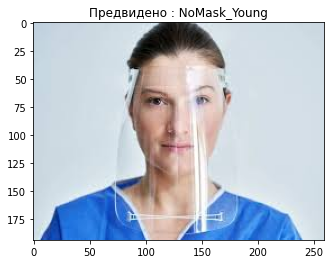

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRVAIr-S0DzTaNbyx9Efov_u8wK4qV4_JyuTg&usqp=CAU")

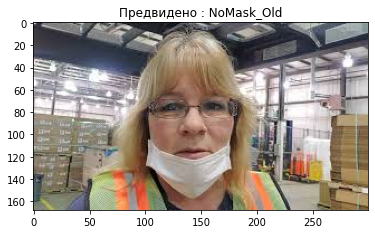

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRK9RF4QLN58YrU8p7MIY6Y-hjA8V6ZJ3xktg&usqp=CAU")